# Master TSI Aix-Marseille Université: SIBIOM. UE Modalités émergentes/ TSI en IRM

Disclosure: this Jupyter is heavily borrowed from online materials found:

https://github.com/mikgroup/sigpy-mri-tutorial

Thanks to all scientists sharing their work !

Welcome !

In this notebook, we will learn to reconstruct MR-Images from k-space with various undersampling.
The notebook uses SigPy to perform parallel imaging compressed sensing reconstruction. These iterative methods can be difficult to implement from scratch and computationally intensive. We will show how SigPy `App`s provide simple interfaces to run these reconstructions.

For a complete list of MRI `App`s, please see: https://sigpy.readthedocs.io/en/latest/mri_app.html

# Setup

MRI `App`s are separately defined in the mri submodule `sigpy.mri`. So in addition to Numpy and SigPy, we will need to import `sigpy.mri`.

In [20]:
%matplotlib inline
import numpy as np
import sigpy as sp
import sigpy.mri as mr
import sigpy.plot as pl

import matplotlib.pyplot as plt

For this notebook, we will be use an 8-channel brain dataset acquired with a Cartesian sampling. The dataset was retrospectively undersampled by 8 with a Poisson-disk undersampling mask. Let us load the dataset and visualize it:

kspace size is:  (8, 230, 180) 



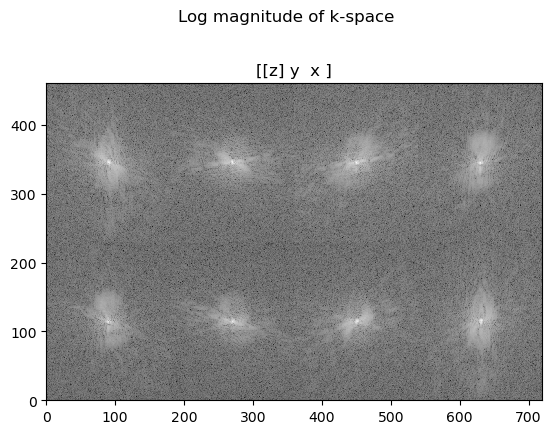

In [32]:
ksp = np.load('data/ksp.npy')

print('kspace size is: ', ksp.shape, '\n')

pl.ImagePlot(ksp, mode='l', z=0, title='Log magnitude of k-space')

Please define the root sum of square operator as "rss"

In [27]:
def rss(input):
    out = np.sum(np.abs(input)**2, axis=0)**0.5
    return out

Now let's look at the image

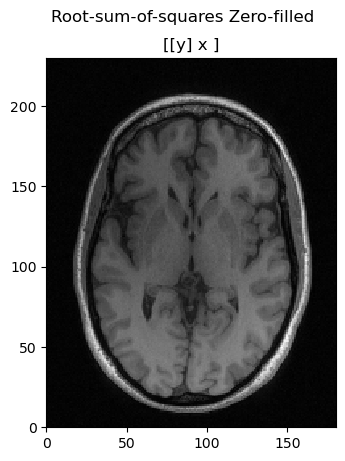

In [28]:
 #img_rss = np.sum(np.abs(sp.ifft(ksp, axes=(-1, -2)))**2, axis=0)**0.5
img_rss = rss(sp.ifft(ksp, axes=(-1, -2)))

pl.ImagePlot(img_rss, title='Root-sum-of-squares image fully sampled')

# Partial Fourier

 Let's try Partial Fourier undersampling & reconstruction using projection onto convex spaces (POCS) seen in class

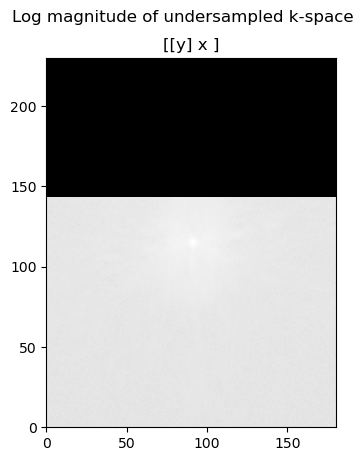

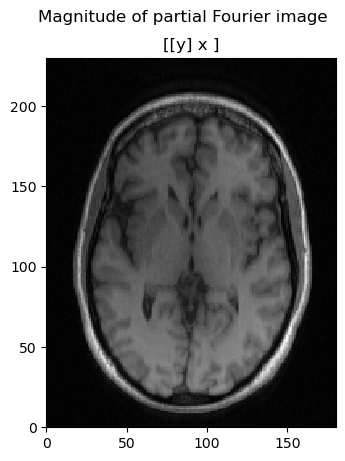

In [69]:
# Define the sampling mask (0 for missing data, 1 for sampled data)
mask = np.ones_like(ksp)
kspsz = ksp.shape

mask[:, np.arange(int(5/8*kspsz[1]),kspsz[1])] = 0  # Example: Simulate partial Fourier sampling

# Define the k-space data with missing values
usksp = ksp * mask

# look at it
pl.ImagePlot(rss(usksp), mode='l', title='Log magnitude of undersampled k-space')

# look at the image now:
pl.ImagePlot(rss(sp.ifft(usksp,axes=(-1,-2))), title='Magnitude of partial Fourier image')

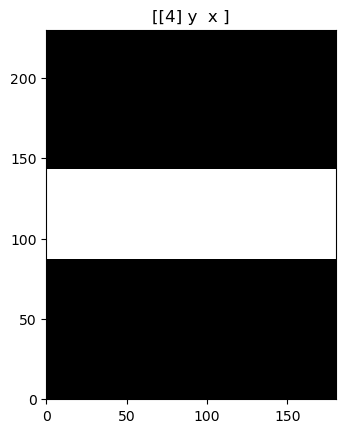

In [78]:
maskflip = np.flip(mask,axis=1)

pl.ImagePlot(maskflip*mask)

In [79]:

# Parameters for POCS reconstruction
num_iterations = 100
l2_reg_weight = 0.01

# Function to perform iterative POCS reconstruction
def iterative_pocs(kspace, mask, num_iterations=100, l2_reg_weight=0.01):
    recon = sp.ifft(kspace, axes=(0, 1))  # Initial reconstruction using inverse FFT

    # define mask of the symmetrical center of kspace
    masksym = mask*np.flip(mask,axis=1)

     # Step 0: Perform inverse FFT to obtain the phase
    recon_phase = np.angle(sp.ifft(masksym*kspace, axes=(-1, -2)))

    for i in range(num_iterations):
        # Step 1: Perform FFT to obtain k-space representation
        kspace_estimate = sp.fft(recon, axes=(-1, -2))

        # Step 2: Update the missing k-space values using the acquired data
        kspace_update = kspace * mask + kspace_estimate * (1 - mask)

        # Step 3.1: Perform inverse FFT to obtain the updated image
        recon_update = sp.ifft(kspace_update, axes=(-1, -2))
        
        # Step 4: Apply a simple L2 norm regularization
        recon = np.abs(recon_update)*np.exp(1j*recon_phase)
        #recon = recon_update + l2_reg_weight * (recon - recon_update)

    return recon


# Perform iterative POCS reconstruction
recon_result = iterative_pocs(usksp, mask)

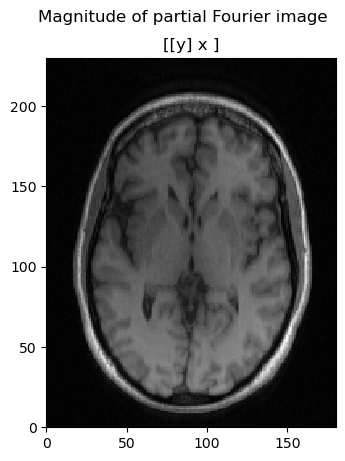

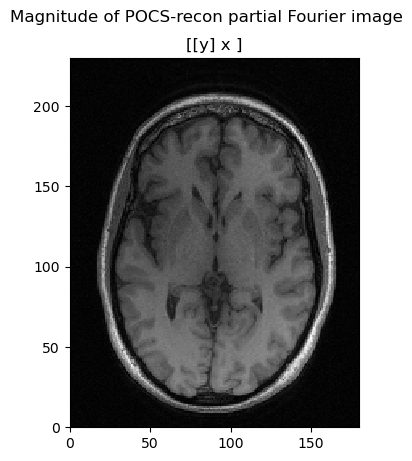

In [83]:
# look at it
pl.ImagePlot(rss(sp.ifft(usksp,axes=(-1,-2))), title='Magnitude of partial Fourier image')

# look at it
pl.ImagePlot(rss(recon_result), title='Magnitude of POCS-recon partial Fourier image')

Clearly the zero-filled reconstruction is not good! POCS is noisier but with sharper details

## Parallel imaging

In the following, we will perform parallel imaging compressed sensing reconstruction using Sigpy. We will first use ESPIRiT to estimate the sensitivity maps from the calibration region, then perform SENSE reconstruction, GRAPPA, L1 wavelet regularized reconstruction, and total variation regularized reconstruction.

(8, 230, 180)


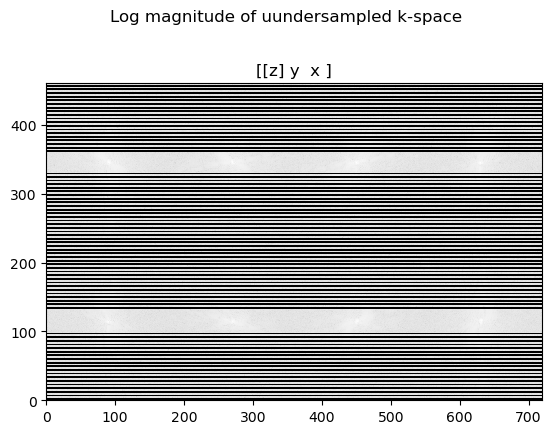

In [99]:
# let's skip one line out of 2 but keep the center of kspace (30 lines)
mask = np.ones_like(ksp)
kspsz = ksp.shape

mask[:,::2] = 0  # one line out 2

mask[:, np.arange(int(0.5*kspsz[1]-15),int(.5*kspsz[1]+15))] = 1  # keep center of kspace

usksp = mask*ksp

print(usksp.shape)

pl.ImagePlot(usksp, mode='l', z=0, title='Log magnitude of uundersampled k-space')

# look at the image
pl.ImagePlot(rss(sp.ifft(usksp,axes=(-1,-2))), title='Magnitude of partial Fourier image')

To perform parallel imaging reconstruction, we will use the ESPIRiT method to estimate the sensitivity maps. To do this, we can use the [EspiritCalib](https://sigpy.readthedocs.io/en/latest/generated/sigpy.mri.app.EspiritCalib.html#sigpy.mri.app.EspiritCalib) App. 

To run an App, you simply do `app.run()`. You should be able to see a progress bar showing the `App`'s progress. 

Note that all MRI `App`s can run on GPU by specifying the option `device`. And of course, you will first need to have a GPU and install `cupy`.

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

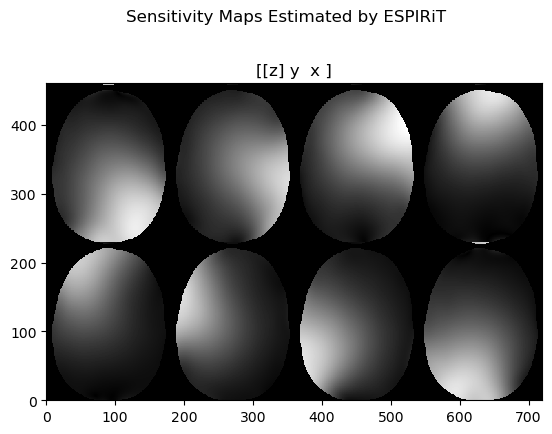

In [100]:
mps = mr.app.EspiritCalib(usksp).run()

pl.ImagePlot(mps, z=0, title='Sensitivity Maps Estimated by ESPIRiT')

## SENSE Recon

With the sensitivity maps ready, we can now run a SENSE reconstruction using the [SenseRecon](https://sigpy.readthedocs.io/en/latest/generated/sigpy.mri.app.SenseRecon.html#sigpy.mri.app.SenseRecon) `App`. We will use an l2 regularization of 0.01 based on trial-and-error with this dataset. Feel free to change it!

Again, we can run the reconstruction on GPU if we specify the `device` option.

SenseRecon:   0%|          | 0/100 [00:00<?, ?it/s]

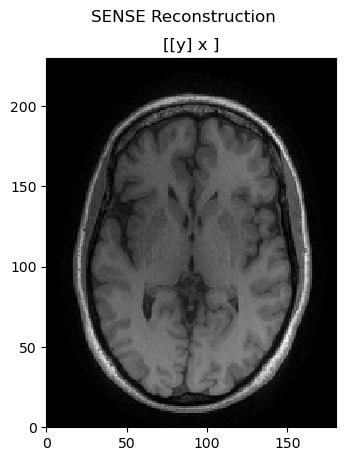

In [101]:
lamda = 0.01
img_sense = mr.app.SenseRecon(usksp, mps, lamda=lamda).run()

pl.ImagePlot(img_sense, title='SENSE Reconstruction')

## L1 Wavelet Regularized Reconstruction

Similarly, we can perform an l1-wavelet regularized reconstruction using [L1WaveletRecon](https://sigpy.readthedocs.io/en/latest/generated/sigpy.mri.app.L1WaveletRecon.html#sigpy.mri.app.L1WaveletRecon).

L1WaveletRecon: 100%|██████████| 100/100 [00:06<00:00, 16.57it/s, resid=1.26E-03]


<IPython.core.display.Javascript object>


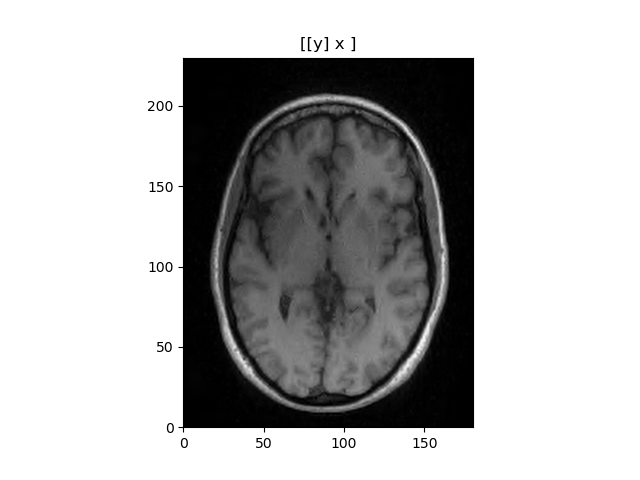

In [25]:
lamda = 0.005
img_l1wav = mr.app.L1WaveletRecon(ksp, mps, lamda).run()

pl.ImagePlot(img_l1wav, title='L1 Wavelet Regularized Reconstruction')

# Total Variation Recon

And we can do total variation regularized reconstruction with [TotalVariationRecon](https://sigpy.readthedocs.io/en/latest/generated/sigpy.mri.app.TotalVariationRecon.html#sigpy.mri.app.TotalVariationRecon).

TotalVariationRecon: 100%|██████████| 100/100 [00:09<00:00, 10.41it/s, resid=9.53E-03]


<IPython.core.display.Javascript object>


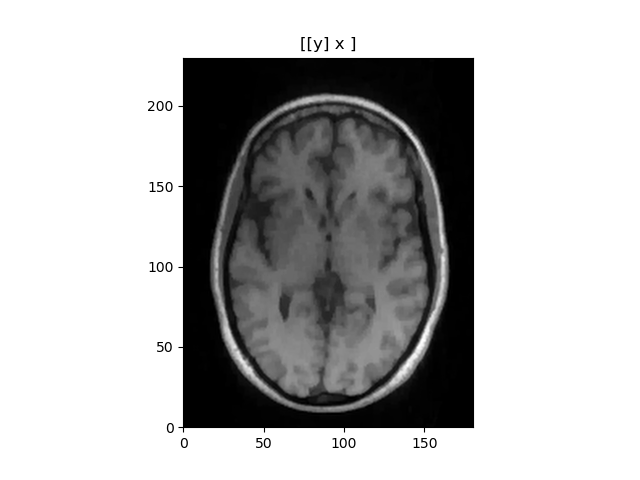

In [26]:
lamda = 0.005
img_tv = mr.app.TotalVariationRecon(ksp, mps, lamda).run()

pl.ImagePlot(img_tv, title='Total Variation Regularized Reconstruction')

And this is how you can do parallel imaging compressed sensing reconstruction with SigPy! We haven't gone through non-Cartesian datasets, but non-Cartesian support can be enabled by passing k-space coordinates to the `coord` option.

In [part 3](03-building-an-l1-wavelet-recon-app.ipynb), we will expose the inner workings of these `App`, and show how you can easily build your own `App`!